<a href="https://colab.research.google.com/github/Rohit1217/VAE/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets,transforms
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((128,),(128,))])

# Load MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=128,shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 88999966.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73638719.65it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32025280.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21429166.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
class Encoder(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,latent_dim):
    super(Encoder,self).__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels
    self.latent_dim=latent_dim
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel+2)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv3=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv4=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv5=nn.Conv2d(out_channels,2,kernel)
    self.conv6=nn.Conv2d(out_channels,2,kernel)
  def forward(self,x):
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)
    mean,log_variance=x[:,0],x[:,1]
    epsilon=torch.randn(self.latent_dim,self.latent_dim).to(get_device())
    z=mean+epsilon*(1+log_variance)
    return mean,log_variance,z

'''enc=Encoder(1,64,5,6)
x=enc(torch.ones(6,1,28,28))
x[0].shape,x[2].shape'''

'enc=Encoder(1,64,5,6)\nx=enc(torch.ones(6,1,28,28))\nx[0].shape,x[2].shape'

In [10]:
class Decoder(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,input_dim):
    super(Decoder,self).__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels
    self.input_dim=input_dim
    self.conv1=nn.ConvTranspose2d(in_channels,out_channels,kernel )
    self.conv2=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv3=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv4=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv5=nn.ConvTranspose2d(out_channels,2,kernel+2)
    self.conv6=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.bn1=


  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=F.relu(self.conv4(x))
    x=F.relu(self.conv5(x))
    mean,variance=x[:,0],x[:,1]
    epsilon=torch.randn(self.input_dim,self.input_dim).to(get_device())
    return mean+epsilon*variance

'''enc=Decoder(1,64,5,28)
x=enc(torch.ones(2,1,6,6))
x.shape,x'''

'enc=Decoder(1,64,5,28)\nx=enc(torch.ones(2,1,6,6))\nx.shape,x'

In [11]:
class VAE(nn.Module):
  def __init__(self,input_dim,latent_dim,in_channels,out_channels,kernel):
    super(VAE,self).__init__()
    self.input_dim=input_dim
    self.latent_dim=latent_dim
    self.encoder=Encoder(in_channels,out_channels,kernel,latent_dim)
    self.decoder=Decoder(in_channels,out_channels,kernel,input_dim)
    self.e=1e-8

  def forward(self,x):
    z,mean,log_variance=self.encoder(x)
    b,w,h=z.shape
    z=z.view(b,1,w,h)
    x=x.view(b,self.input_dim,self.input_dim)
    x_re=self.decoder(z)
    return x_re,x,mean,log_variance

'''vae=VAE(28,6,1,64,5)
x=vae(torch.randn(6,1,28,28))
x[0].shape,x[1].shape,x[2].shape,x[3].shape,x'''

'vae=VAE(28,6,1,64,5)\nx=vae(torch.randn(6,1,28,28))\nx[0].shape,x[1].shape,x[2].shape,x[3].shape,x'

In [17]:
def Loss(x_re,x_or,mean,log_variance):
  re_loss=F.binary_cross_entropy_with_logits(x_re,x_or)
  b,c,c=mean.shape
  log_variance=log_variance.view(b,c*c)
  mean=mean.view(b,c*c)
  kl=torch.sum(0.5*(1+2*log_variance-torch.pow(log_variance,2)-torch.pow(mean,2)),dim=1)
  kl=torch.mean(kl)
  return (re_loss+kl)
'''Loss(x[0],x[1],x[2],x[3])'''

'Loss(x[0],x[1],x[2],x[3])'

In [18]:
model=VAE(28,6,1,64,5)
model=model.to(get_device())
epochs=50
optimizer=optim.Adam(model.parameters(),lr=0.0001)
for epoch in range(epochs):
  total_loss=0
  count=0
  for x,_ in trainloader:
    x=x.to(get_device())
    x_re,x,mean,log_variance=model(x)
    loss=Loss(x_re,x,mean,log_variance)

    total_loss+=loss.item()
    count+=1
    print(total_loss)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    #for name, param in model.decoder.named_parameters():
    #  if param.grad is not None:
    #    pass
    #      #print(f'a')
      #print(x_re,x,mean,log_variance,loss)


  print(f'total_loss{total_loss},mse_loss{total_loss/count},epoch{epoch}')

-10.40577220916748
-17.277010440826416
-55.018274784088135
-110.26222467422485
-233.97408533096313
-514.3406624794006
-845.3238167762756
-1925.7286019325256
-3083.226770877838
-5467.070276737213
-10309.811487674713
-16771.887659549713
-27611.445276737213
-46957.66012048721
-75880.99019861221
-129116.24801111221
-200827.9433236122
-303734.6151986122
-483904.6776986122
-726155.2401986122
-1068454.2089486122
-1413259.7089486122
-1979216.7714486122
-2980795.271448612
-4331390.521448612
-5976596.646448612
-8372406.896448612
-10894162.146448612
-14905905.646448612
-18974835.396448612
-23891855.396448612
-33579386.39644861
-44404729.39644861
-58207576.39644861
-74615047.39644861
-93934359.39644861
-125706543.39644861
-171649511.3964486
-223240219.3964486
-269496395.3964486
-347136139.3964486
-429554635.3964486
-517058091.3964486
-616366155.3964486
-750298675.3964486
-918018835.3964486
-1110245843.3964486
-1273551651.3964486
-1636481763.3964486
-2051661667.3964486
-2403940835.3964486
-28759242

KeyboardInterrupt: 

torch.Size([28, 28])


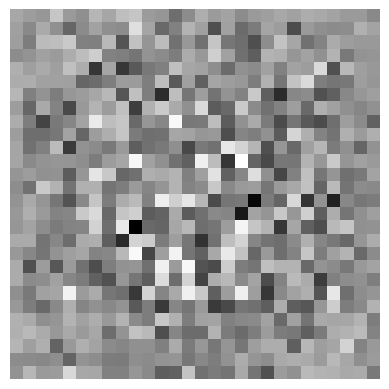

In [19]:
#print(x)
z=torch.randn(6,1,6,6)
z=z.to('cuda:0')
x=model.decoder(z)
print(x[0].shape)
x=x[0]
x=x.view(28,28)
#x=data[0].view(28,28)
x=x.to('cpu')
image_np = x.detach().numpy()

# Display the image using matplotlib
plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()